In [1]:
import numpy as np 
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.colors as cls
%matplotlib inline
from ipywidgets import interact, FloatSlider
from scipy.optimize import curve_fit
import time

### For one dimension:
$$DE_{i} = \sum_j\frac{1}{\sigma \sqrt{2\pi}}\exp\left( -\frac{(x_{p_i}-x_{d_j})^2}{2\sigma^2}                  \right)$$

### For two dimensions where $x$ and $y$ are uncorrelated:
$$DE_{i} = \sum_j\frac{1}{2\pi\sigma_x \sigma_y }\exp\left( -\frac{(x_{p_i}-x_{d_j})^2}{2\sigma_x^2} -\frac{(y_{p_i}-y_{d_j})^2}{2\sigma_y^2}                  \right)$$

# KDE 1D

In [2]:
class KDE():
    def __init__(self, seed = 123, N = 10000):
        self.seed = seed
        self.dataSet = self.getData(n = N)
        self.xMin = -0.25
        self.xMax = 1.75
        self.nBins = 50
        self.bins = np.linspace(self.xMin,self.xMax,self.nBins+1) 
        self.binSize = (self.xMax-self.xMin)/self.nBins
        self.binCenters = (self.bins[0:-1]+self.bins[1:])/2
        self.weights = np.full(len(self.dataSet), 1./self.binSize) # to get density

    def getData(self, n, mu1=0, sig1=0.1, mu2=1, sig2=0.3, frac1=0.7):
        np.random.seed(self.seed)
        data1 = np.random.normal(mu1, sig1, int(n*frac1))
        data2 = np.random.normal(mu2, sig2, int(n*(1-frac1)))
        dataC = np.concatenate((data1,data2))
        np.random.shuffle(dataC)
        return dataC
    
    ### Normalized Gaussian Distribution ###
    def myKDEgauss(self, xp , sigma=0.2):
        xd = self.dataSet
        gausArr = np.exp(-0.5* ((xp.reshape(-1,1) - xd.reshape(-1))/sigma)**2)
        norm = 1.0/(sigma*np.sqrt(2*np.pi))
        return np.sum(gausArr, axis=1)*norm

    def makePlot(self):        
        counts, _b, _p = plt.hist(self.dataSet, bins=self.nBins, range=[self.xMin,self.xMax], weights=self.weights, label = 'dataHistWeighted'); 

        popt, pcov = curve_fit(self.myKDEgauss, self.binCenters, counts, bounds = [0.001,0.108])
        est_kdeGauss  = self.myKDEgauss(self.binCenters,sigma=popt[0]) 
        plt.plot(self.binCenters, est_kdeGauss, label='kdeGauss')
        plt.ylabel('counts density'); plt.title("optimized simga = " + str(np.round(popt[0], 5)))
        plt.legend(); plt.show(); plt.close()
    


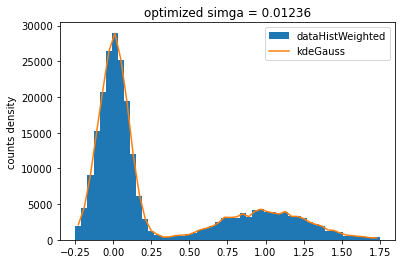

In [3]:
a = KDE(seed = 315, N=10000)
a.makePlot()

# KDE 2D

In [4]:
class KDE2D():
    def __init__(self, seed1 = 123, N = 10000, seed2 = 456, bins = 25):
        self.dataSetX = self.getData(n = N, seed=seed1)
        self.dataSetY = self.getData(n = N, seed=seed2)
        self.dataSet = np.array([self.dataSetX, self.dataSetY])
        self.xMin = -0.25
        self.xMax = 1.75
        self.nBins = bins
        self.bins = np.linspace(self.xMin,self.xMax,self.nBins+1) 
        self.binSize = (self.xMax-self.xMin)/self.nBins
        self.binCenters = (self.bins[0:-1]+self.bins[1:])/2
        self.xPred = self.getXPred(self.binCenters)
        self.weights = np.full(len(self.dataSetX), 1./self.binSize**2) # to ensure normal area for histogram        
    
    def KDE2Dfit(self, xPred, sigx):
        xpArr, ypArr = xPred[0], xPred[1]
        xDArr, yDArr = self.dataSetX, self.dataSetY
        kdeArr = self.Gauss2D( xpArr, xDArr, ypArr, yDArr, sigx=sigx)
        return np.sum(kdeArr, axis = 1)
    
    def Gauss2D(self, xp, xD, yp, yD, sigx):
        rho = 0; sigy = sigx;
        norm = 1/(2*np.pi*sigx*sigy)
        gausArr = np.exp(-0.5* (((xp.reshape(-1,1) - xD.reshape(-1))/sigx)**2  + ((yp.reshape(-1,1) - yD.reshape(-1))/sigy)**2  )   )
        return gausArr*norm
                
    def getKDE(self, sigma = False):
        cmap = plt.cm.viridis
        fig, axs = plt.subplots(1, 3, figsize=(24,6), constrained_layout=True)
        plt.rc('font', size=15) 
        
        counts, _xE, _yE,  = np.histogram2d(self.dataSet[0],self.dataSet[1], bins=[self.nBins,self.nBins], range=[[self.xMin,self.xMax],[self.xMin,self.xMax]], weights=self.weights); 
        axs[0].imshow(counts, origin = 'lower', extent = np.array([self.xMin,self.xMax,self.xMin,self.xMax]))
        norm = cls.Normalize(vmin=np.amin(counts), vmax=np.amax(counts))
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        axs[0].set_title('dataHistWeighted')
        plt.colorbar(sm, ax= axs[0])
        
        if not sigma:
            print("Fitting data for sigma ...")
            start = time.time()
            popt, pcov = curve_fit(self.KDE2Dfit, self.xPred, counts.flatten(), bounds = [0.001,0.108])
            print('Time taken =', np.round(time.time()-start,5), 'sec')
            sigma = popt[0]
            print("Optimal sigma =", sigma)
        else:
            print("sigma =", sigma)
        
        pred = (self.KDE2Dfit(self.xPred, sigma)).reshape(len(self.binCenters),len(self.binCenters))
        axs[1].imshow(pred, origin = 'lower', extent = np.array([self.xMin,self.xMax,self.xMin,self.xMax]))
        axs[1].set_title('predicted; sigma = '+ str(np.round(sigma, 5)))
        norm = cls.Normalize(vmin=np.amin(pred), vmax=np.amax(pred))
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        plt.colorbar(sm, ax= axs[1])

        diff = counts - pred
        axs[2].imshow(diff, origin = 'lower', extent = np.array([self.xMin,self.xMax,self.xMin,self.xMax]))
        axs[2].set_title('difference')
        norm = cls.Normalize(vmin=np.amin(diff), vmax=np.amax(diff))
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        plt.colorbar(sm, ax= axs[2])
        
        plt.show(); plt.close()

    def getXPred(self, x, y = None):
        if y is None:
            y = x
        k = np.meshgrid(x, y)
        return np.array([k[0].flatten(), k[1].flatten()])
        
    def getData(self, n, mu1=0, sig1=0.1, mu2=1, sig2=0.3, frac1=0.5, seed = 0):
        np.random.seed(seed)
        data1 = np.random.normal(mu1, sig1, int(n*frac1))
        data2 = np.random.normal(mu2, sig2, int(n*(1-frac1)))
        dataC = np.concatenate((data1,data2))
        np.random.shuffle(dataC)
        return dataC
    

    

In [5]:
b = KDE2D(N=10000, bins = 25)


Fitting data for sigma ...
Time taken = 1.41796 sec
Optimal sigma = 0.037602114181329985


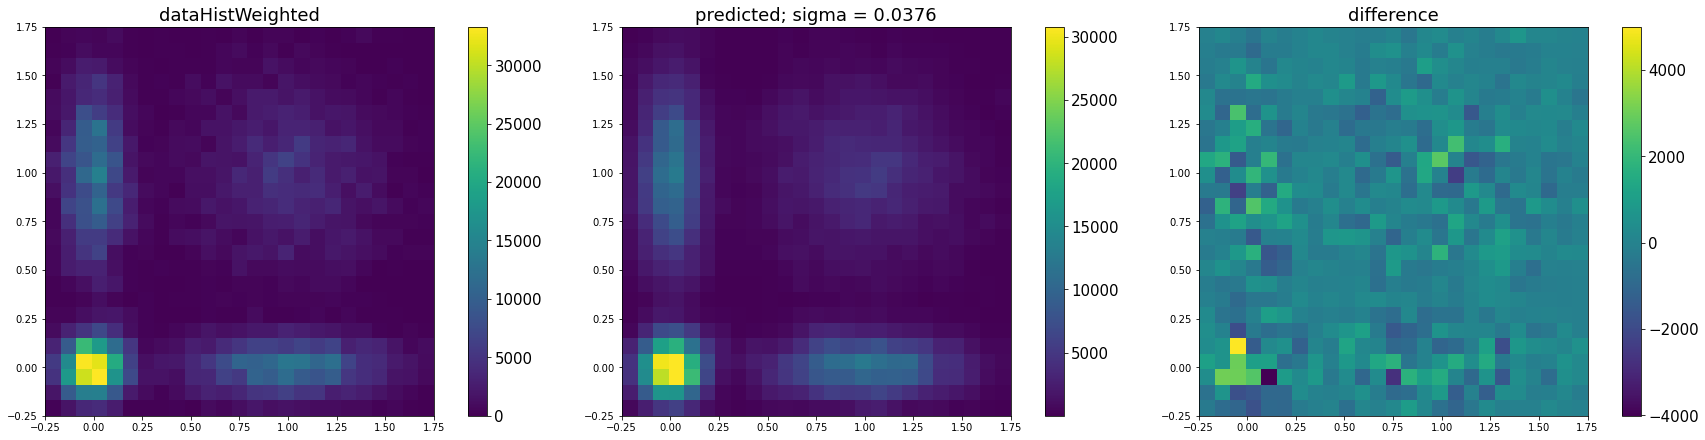

In [6]:
b.getKDE()

Fitting data for sigma ...
Time taken = 1.38562 sec
Optimal sigma = 0.037602114181329985


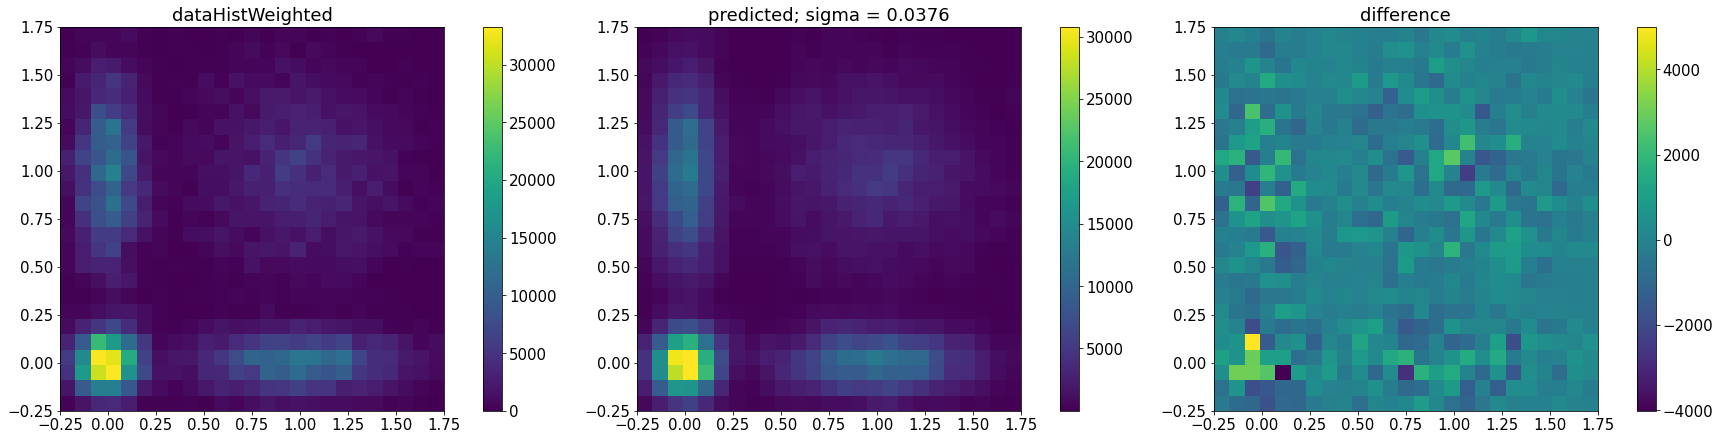

sigma = 0.001


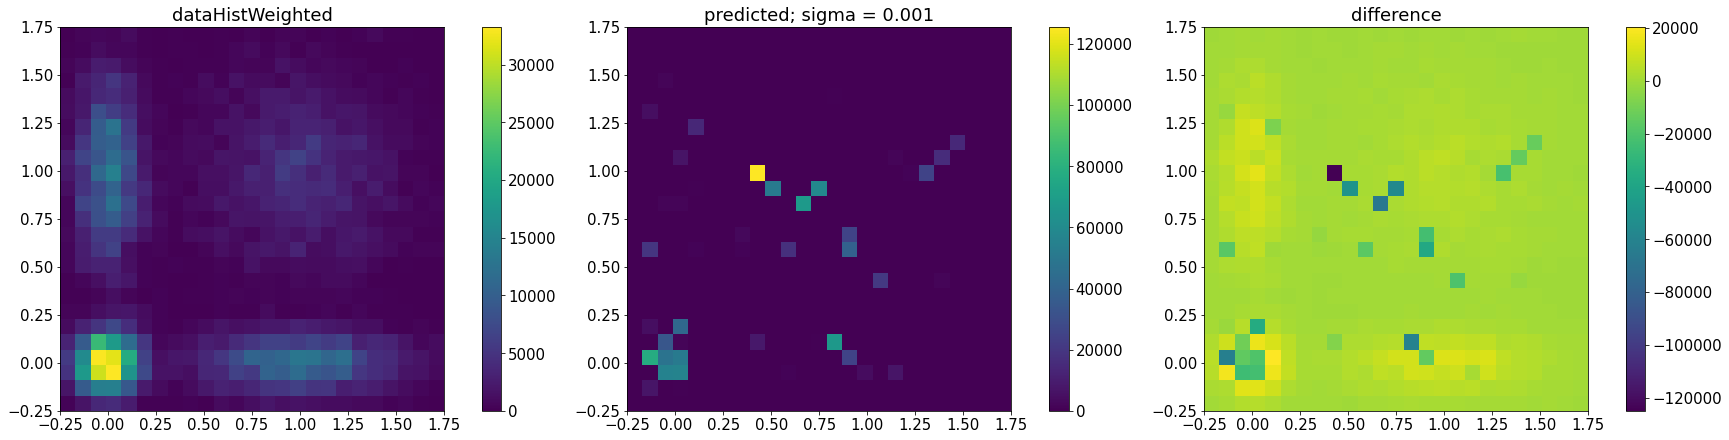

sigma = 0.0002


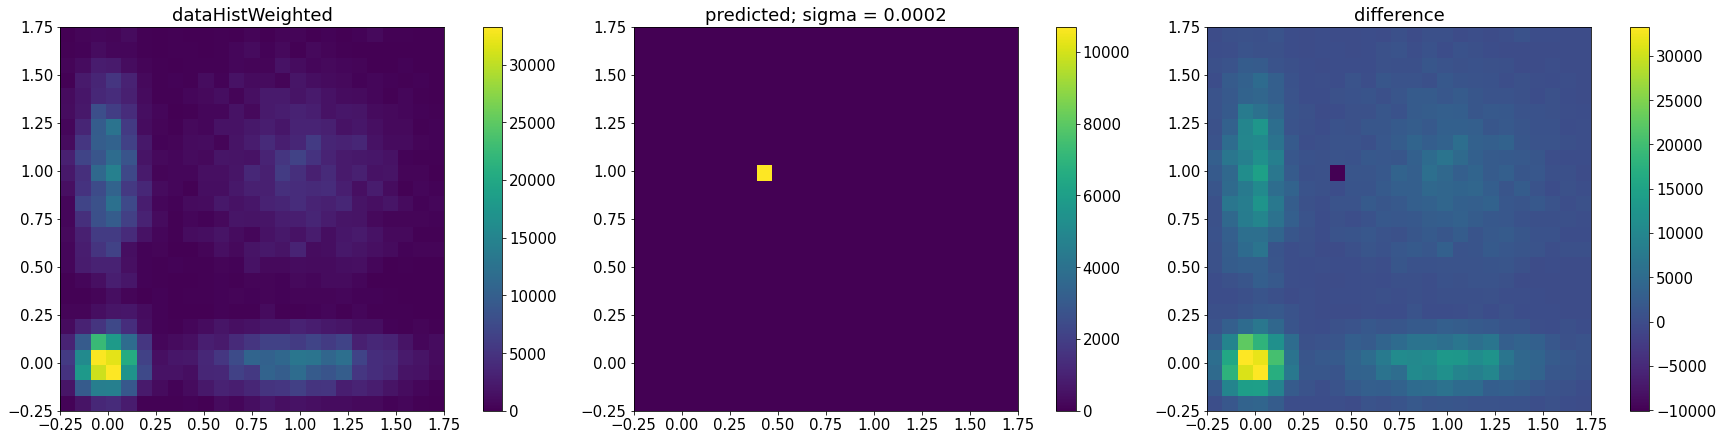

sigma = 0.02


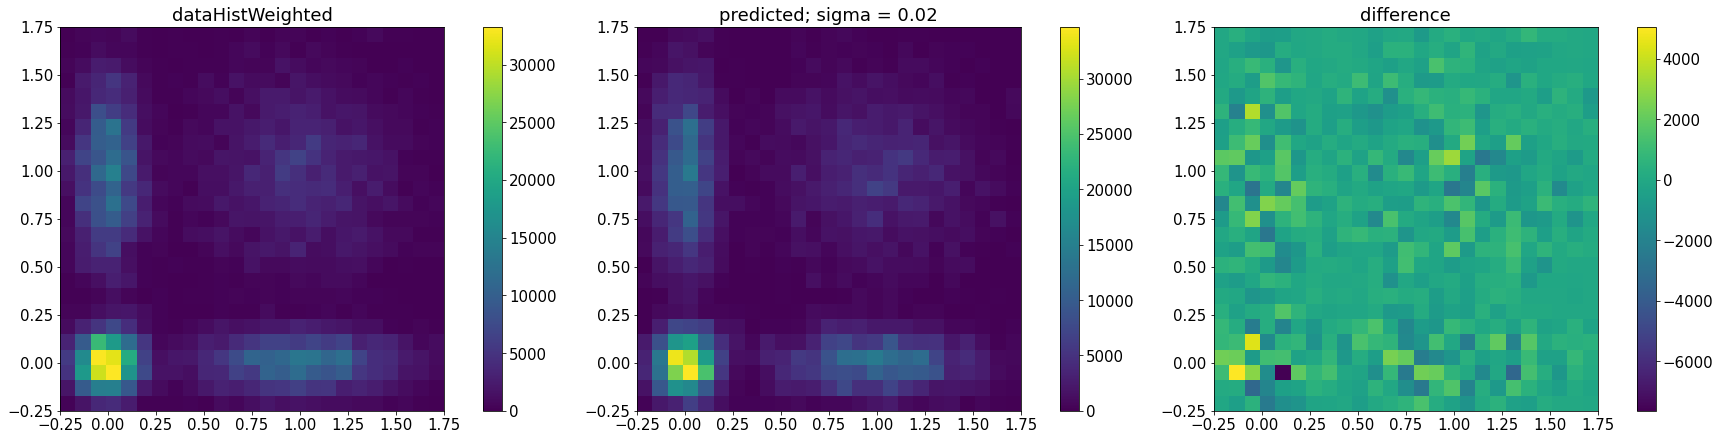

In [7]:
for s in [0,0.001, 0.0002, 0.02]:
    b.getKDE(sigma=s)

# KDE 3D

In [8]:
class KDE3D():
    def __init__(self, seed1 = 123, N = 10000, seed2 = 456, bins = 25, seed3 = 789):
        self.dataSetX = self.getData(n = N, seed=seed1)
        self.dataSetY = self.getData(n = N, seed=seed2)
        self.dataSetZ = self.getData(n = N, seed=seed3)
        self.dataSet = np.array([self.dataSetX, self.dataSetY, self.dataSetZ])
        self.xMin = -0.25
        self.xMax = 1.75
        self.nBins = bins
        self.bins = np.linspace(self.xMin,self.xMax,self.nBins+1) 
        self.binSize = (self.xMax-self.xMin)/self.nBins
        self.binCenters = (self.bins[0:-1]+self.bins[1:])/2
        self.xPred = self.getPred(self.binCenters)
        self.weights = np.full(len(self.dataSetX), 1./self.binSize**3) # to ensure normal area for histogram        
        self.plotArr = None
    
    def KDE3Dfit(self, xPred, sig):
        xpArr, ypArr, zpArr = xPred[0], xPred[1], xPred[2]
        xDArr, yDArr, zDArr = self.dataSetX, self.dataSetY, self.dataSetZ
        kdeArr = self.Gauss3D( xpArr, xDArr, ypArr, yDArr, zpArr, zDArr, sig=sig)
        return np.sum(kdeArr, axis = 1)
    
    def Gauss3D(self, xp, xD, yp, yD, zp, zD, sig):
        rho = 0; 
        norm = 1/(((2*np.pi)**1.5)*sig**3)
        gausArr = np.exp(-0.5* (((xp.reshape(-1,1) - xD.reshape(-1))/sig)**2  + ((yp.reshape(-1,1) - yD.reshape(-1))/sig)**2  + ((zp.reshape(-1,1) - zD.reshape(-1))/sig)**2)   )
        return gausArr*norm
                
    def getKDE(self, sigma = False):
        counts, _edges,  = np.histogramdd(self.dataSet.T, bins=[self.nBins,self.nBins,self.nBins], range=[[self.xMin,self.xMax],[self.xMin,self.xMax],[self.xMin,self.xMax]], weights=self.weights); 

        if not sigma:
            print("Fitting data for sigma ...")
            start = time.time()
            popt, pcov = curve_fit(self.KDE3Dfit, self.xPred, counts.flatten(), bounds = [0.001,0.108])
            print('Time taken =', np.round(time.time()-start,5), 'sec')
            sigma = popt[0]
            print("Optimal sigma =", sigma)
        else:
            print("sigma =", sigma)
        
        pred = (self.KDE3Dfit(self.xPred, sigma)).reshape(len(self.binCenters),len(self.binCenters),len(self.binCenters))        
        diff = counts - pred
        self.plotArr = [counts, pred, diff]
        return self.plotArr
    
    def flipBook3D(self, i):
        fig, axs = plt.subplots(1, 3, figsize=(24,6), constrained_layout=True)
        plt.rc('font', size=15)
        cmap = plt.cm.viridis
        typeArr = ['weightedHist', 'KDE_fit', 'difference']
        for p in range(3):
            axs[p].imshow(self.plotArr[p][int(i)], origin = 'lower', extent = np.array([-0.25,1.75,-0.25,1.75]))
            norm = cls.Normalize(vmin=np.amin(self.plotArr[p]), vmax=np.amax(self.plotArr[p]))
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            axs[p].set_title('slice '+ str(int(i))+': '+ typeArr[p])
            plt.colorbar(sm, ax= axs[p])

    def getPred(self, x, y = None, z = None):
        if y is None:
            y = x
        if z is None:
            z = x
        k = np.meshgrid(x, y, z)
        return np.array([k[0].flatten(), k[1].flatten(), k[2].flatten()])
        
    def getData(self, n, mu1=0, sig1=0.1, mu2=1, sig2=0.3, frac1=0.5, seed = 0):
        np.random.seed(seed)
        data1 = np.random.normal(mu1, sig1, int(n*frac1))
        data2 = np.random.normal(mu2, sig2, int(n*(1-frac1)))
        dataC = np.concatenate((data1,data2))
        np.random.shuffle(dataC)
        return dataC
    

    

In [13]:
c = KDE3D(N=10000)

In [14]:
plotArr = c.getKDE(sigma = 0.005)
interact(c.flipBook3D, i=FloatSlider(min=0, max=24, step=1, value=0));

sigma = 0.005


interactive(children=(FloatSlider(value=0.0, description='i', max=24.0, step=1.0), Output()), _dom_classes=('w…

In [12]:
# Fit with fewer events
c = KDE3D(N=100)
plotArr = c.getKDE(sigma = 0)
interact(c.flipBook3D, i=FloatSlider(min=0, max=24, step=1, value=0));

Fitting data for sigma ...
Time taken = 0.38296 sec
Optimal sigma = 0.10799999999999998


interactive(children=(FloatSlider(value=0.0, description='i', max=24.0, step=1.0), Output()), _dom_classes=('w…